In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.vision import *
from fastai.metrics import error_rate

In [3]:
bs = 64

In [4]:
path = Path('/kaggle/input/lego-dataset')
path.ls()


[PosixPath('/kaggle/input/lego-dataset/Test.csv'),
 PosixPath('/kaggle/input/lego-dataset/train'),
 PosixPath('/kaggle/input/lego-dataset/Train.csv'),
 PosixPath('/kaggle/input/lego-dataset/test')]

In [5]:
path_anno = path/'train'
fn_paths = get_image_files(path_anno)

In [6]:
df = pd.read_csv(path/'Train.csv')
df.head()

,name,category
0,1.png,9
1,2.png,3
2,3.png,9
3,4.png,8
4,5.png,13


In [7]:
def get_labels(file_path):
        for row in df.itertuples():
            if '/'+row.name in str(file_path):            
                return row.category
    

In [8]:
labels = list(map(get_labels, fn_paths))

In [9]:
tfms = get_transforms()
data = ImageDataBunch.from_lists(path, fn_paths, labels=labels, ds_tfms=tfms, size=200, bs=bs, valid_pct=0.25
                                  ).normalize(imagenet_stats)

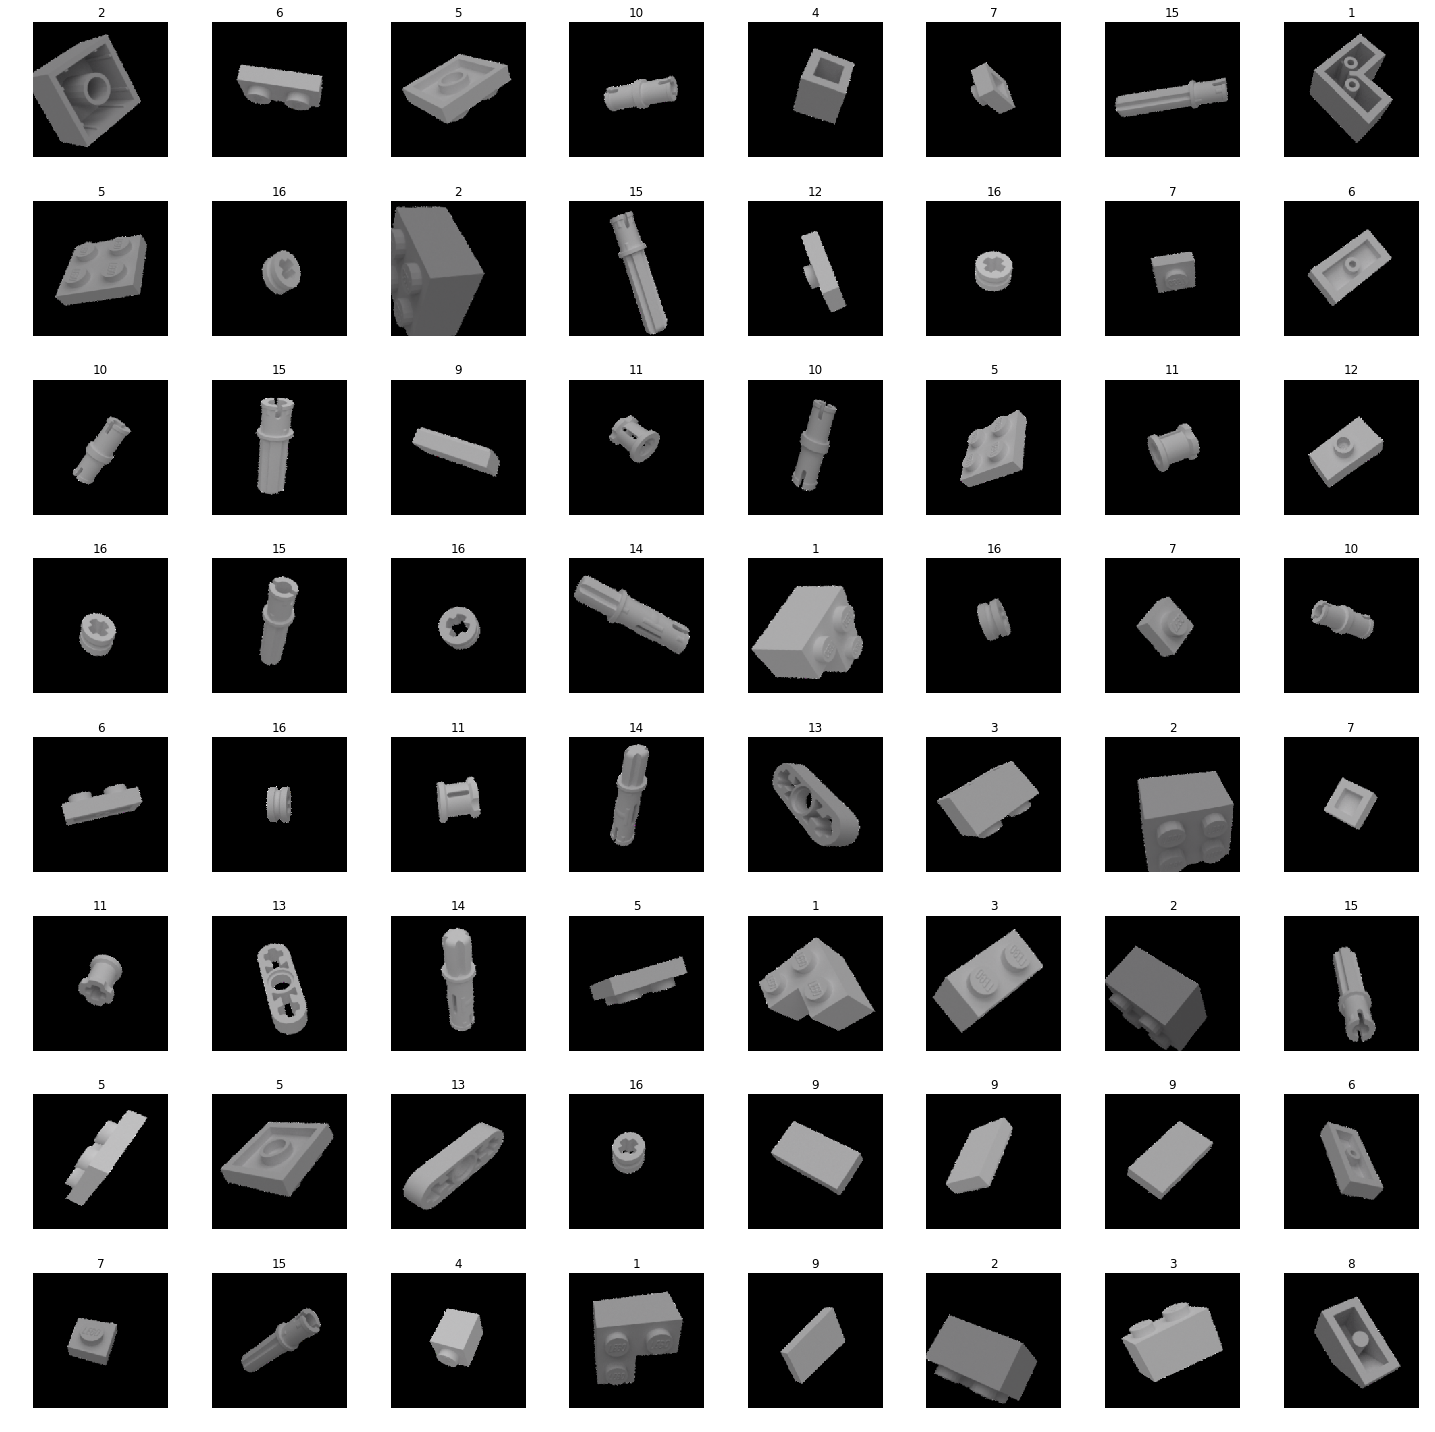

In [10]:
data.show_batch(rows=20, figsize=(20,20))

In [11]:
data.classes, data.c, len(data.train_ds), len(data.valid_ds)

([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16], 16, 3349, 1116)

In [12]:
!mkdir -p /root/.cache/torch/checkpoints/
!cp /kaggle/input/fast-ai-models/resnet50-19c8e357.pth /root/.cache/torch/checkpoints/resnet50-19c8e357.pth

In [13]:
learn = cnn_learner(data, models.resnet50, metrics=accuracy, model_dir=Path('/kaggle/input/fast-ai-models'))

In [14]:
learn.model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): Conv2d(64, 256

In [15]:
learn.fit_one_cycle(10)

epoch,train_loss,valid_loss,accuracy,time
0,1.667704,1.260836,0.621864,00:34
1,0.968385,0.483295,0.831541,00:28
2,0.667613,0.404844,0.858423,00:29
3,0.498949,0.308162,0.887097,00:28
4,0.387941,0.233754,0.909498,00:28
5,0.308167,0.215731,0.915771,00:28
6,0.261815,0.153495,0.938172,00:28
7,0.213474,0.172830,0.939068,00:28
8,0.189086,0.148556,0.950717,00:28
9,0.165895,0.142981,0.953405,00:28


In [16]:
learn.model_dir = '/kaggle/output/fast-ai-models/'

In [17]:
learn.save('/kaggle/output/fast-ai-models/stage-1-50')

In [18]:
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

True

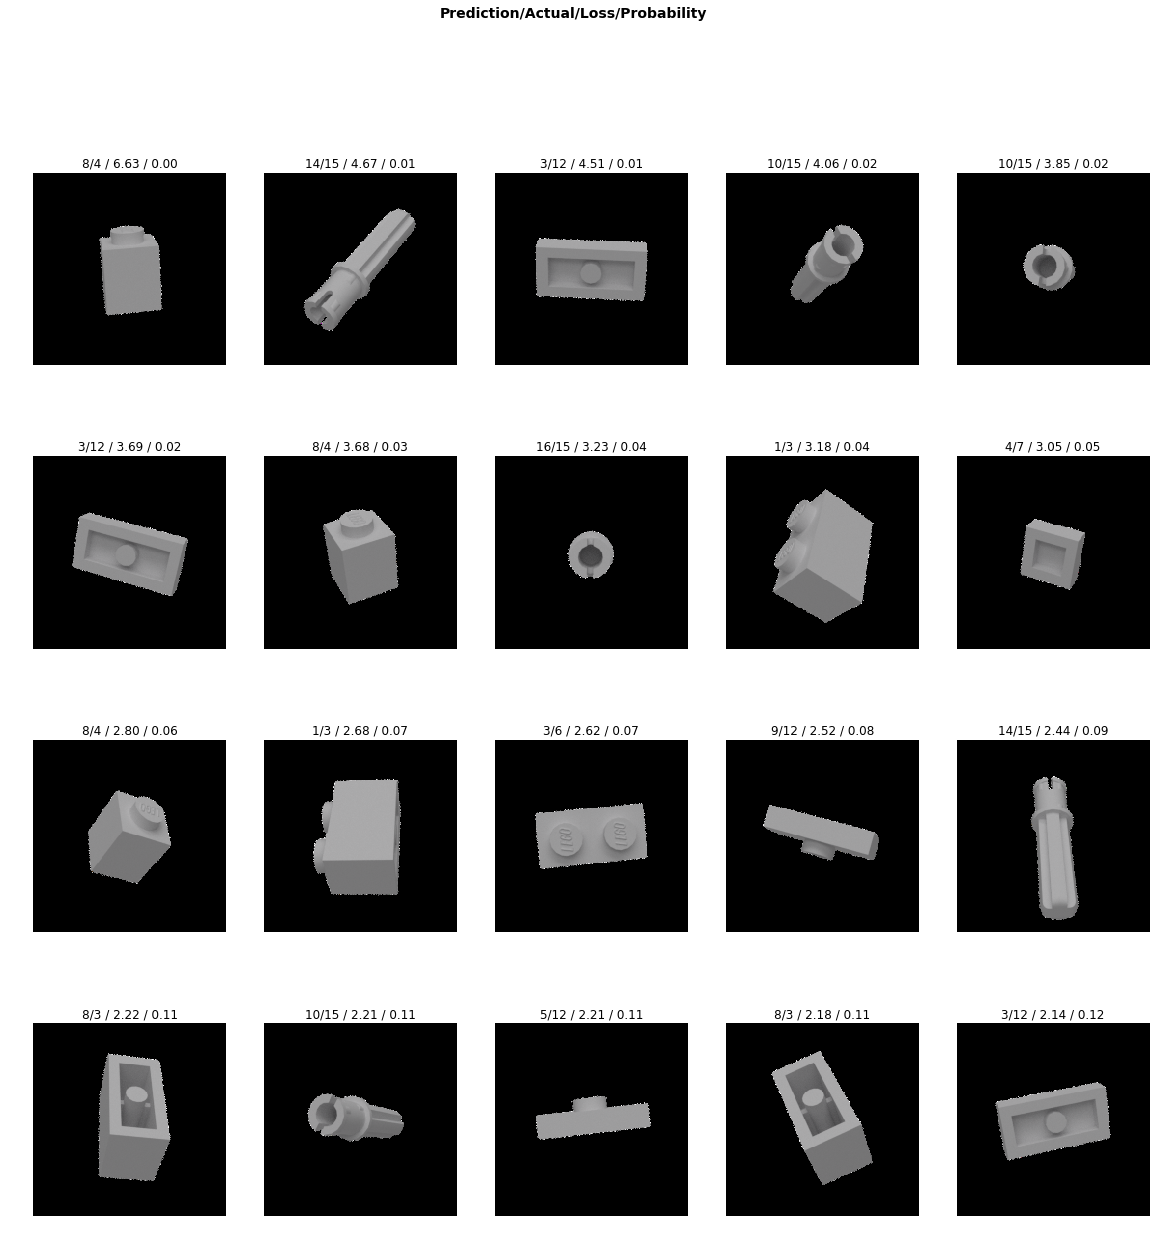

In [19]:
interp.plot_top_losses(20, figsize=(20,20))

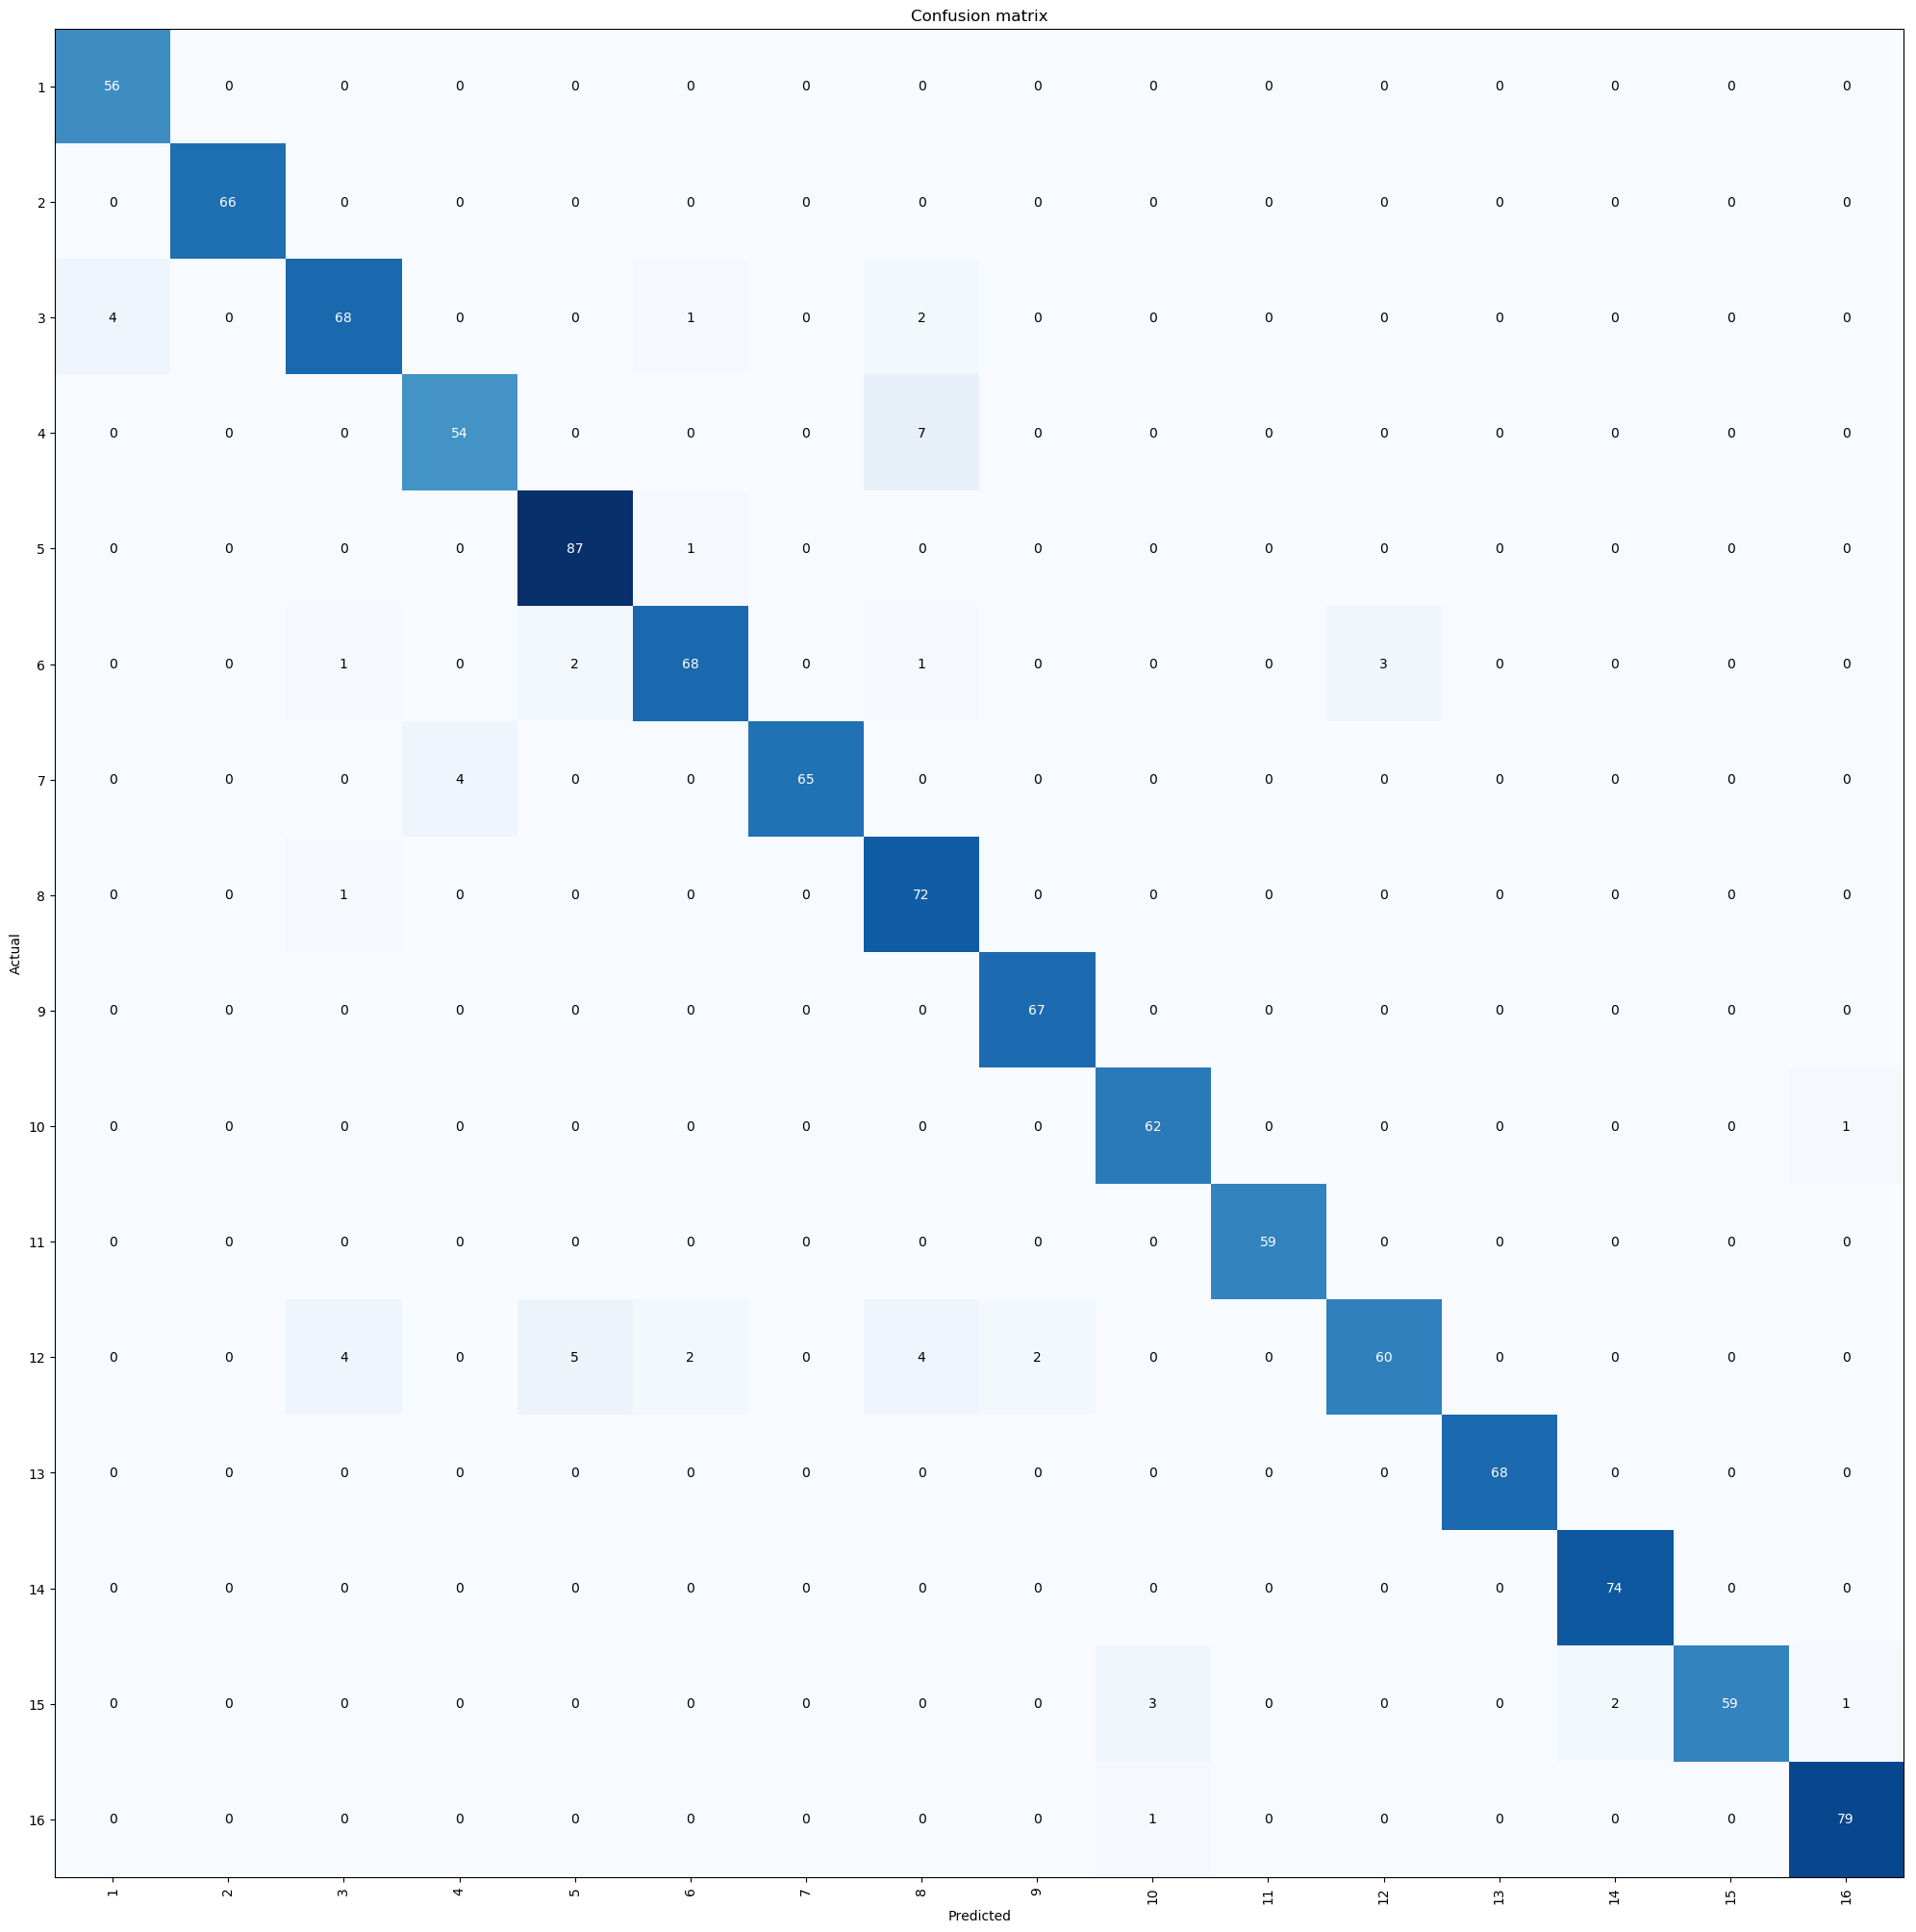

In [20]:
interp.plot_confusion_matrix(figsize=(20,20), dpi=100)

In [21]:
interp.most_confused(min_val=2)

[(4, 8, 7),
 (12, 5, 5),
 (3, 1, 4),
 (7, 4, 4),
 (12, 3, 4),
 (12, 8, 4),
 (6, 12, 3),
 (15, 10, 3),
 (3, 8, 2),
 (6, 5, 2),
 (12, 6, 2),
 (12, 9, 2),
 (15, 14, 2)]

In [22]:
learn.unfreeze()

In [23]:
learn.fit_one_cycle(2)

epoch,train_loss,valid_loss,accuracy,time
0,0.610492,1.450714,0.637097,00:29
1,0.358518,0.086125,0.970430,00:29


In [24]:
learn.load('/kaggle/output/fast-ai-models/stage-1-50');

In [25]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


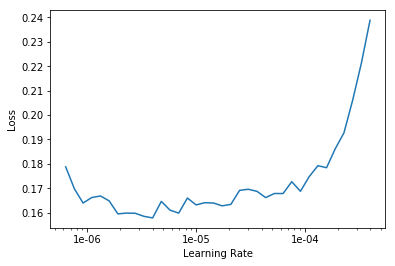

In [26]:
learn.recorder.plot()

In [27]:
learn.unfreeze()
learn.fit_one_cycle(10, max_lr=slice(1e-6,1e-4))

epoch,train_loss,valid_loss,accuracy,time
0,0.163840,0.129025,0.956989,00:29
1,0.143138,0.127460,0.953405,00:28
2,0.145837,0.111194,0.963262,00:29
3,0.133360,0.092698,0.965054,00:28
4,0.123080,0.101751,0.965950,00:29
5,0.117626,0.100977,0.964158,00:28
6,0.105036,0.077197,0.972222,00:30
7,0.094017,0.075822,0.974014,00:28
8,0.086259,0.079249,0.974014,00:29
9,0.089315,0.079172,0.973118,00:29


In [28]:
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

True

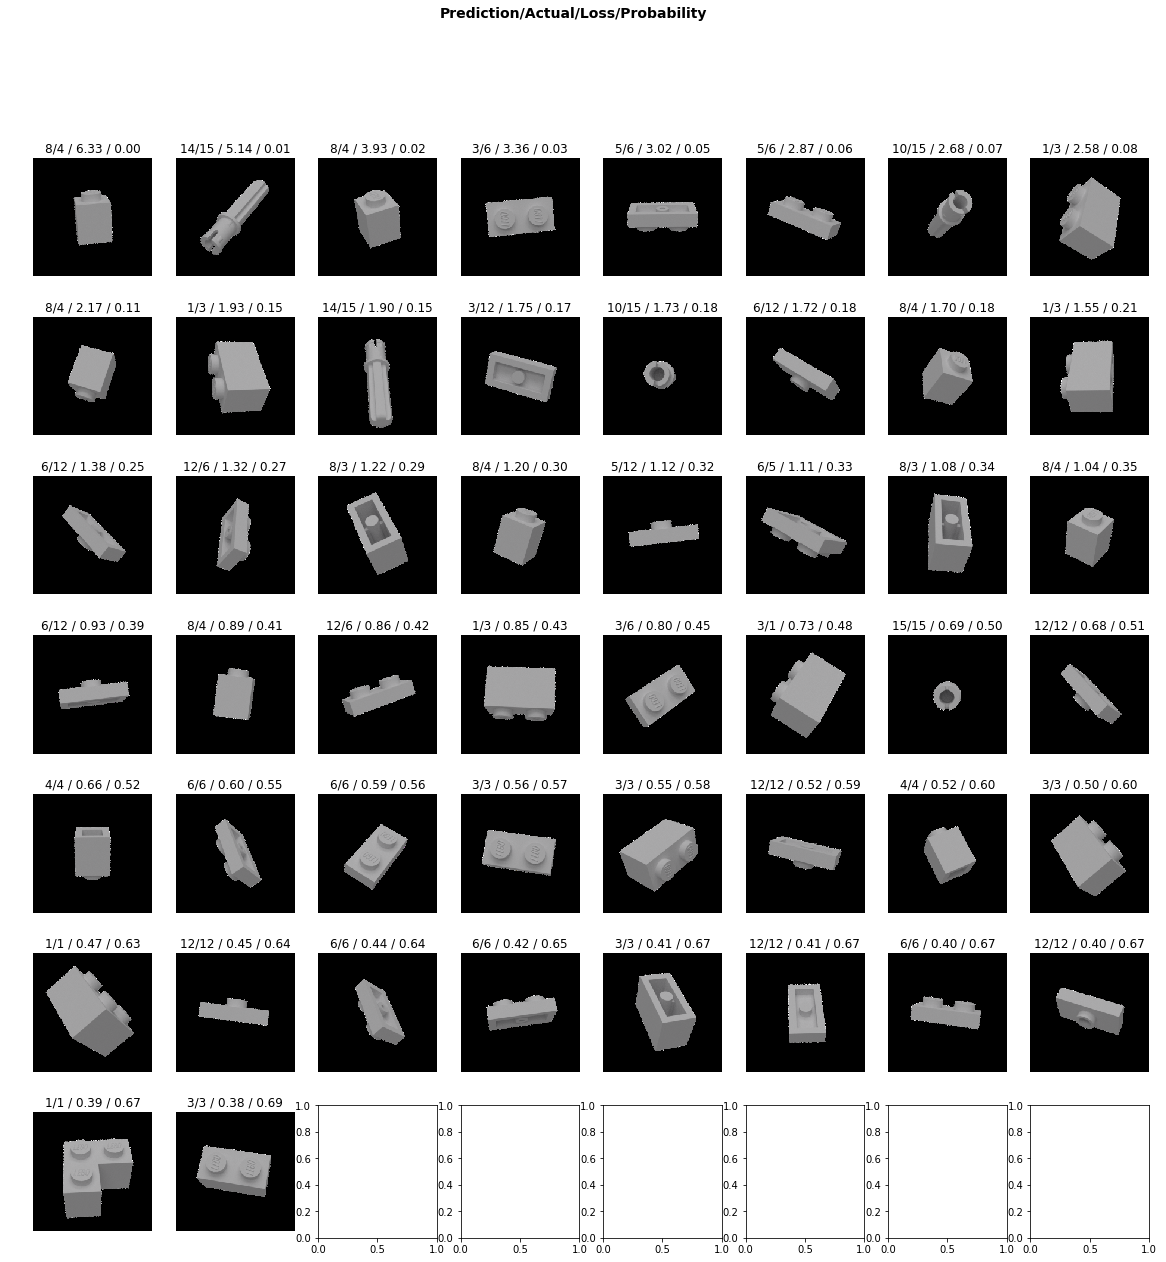

In [29]:
interp.plot_top_losses(50, figsize=(20,20))

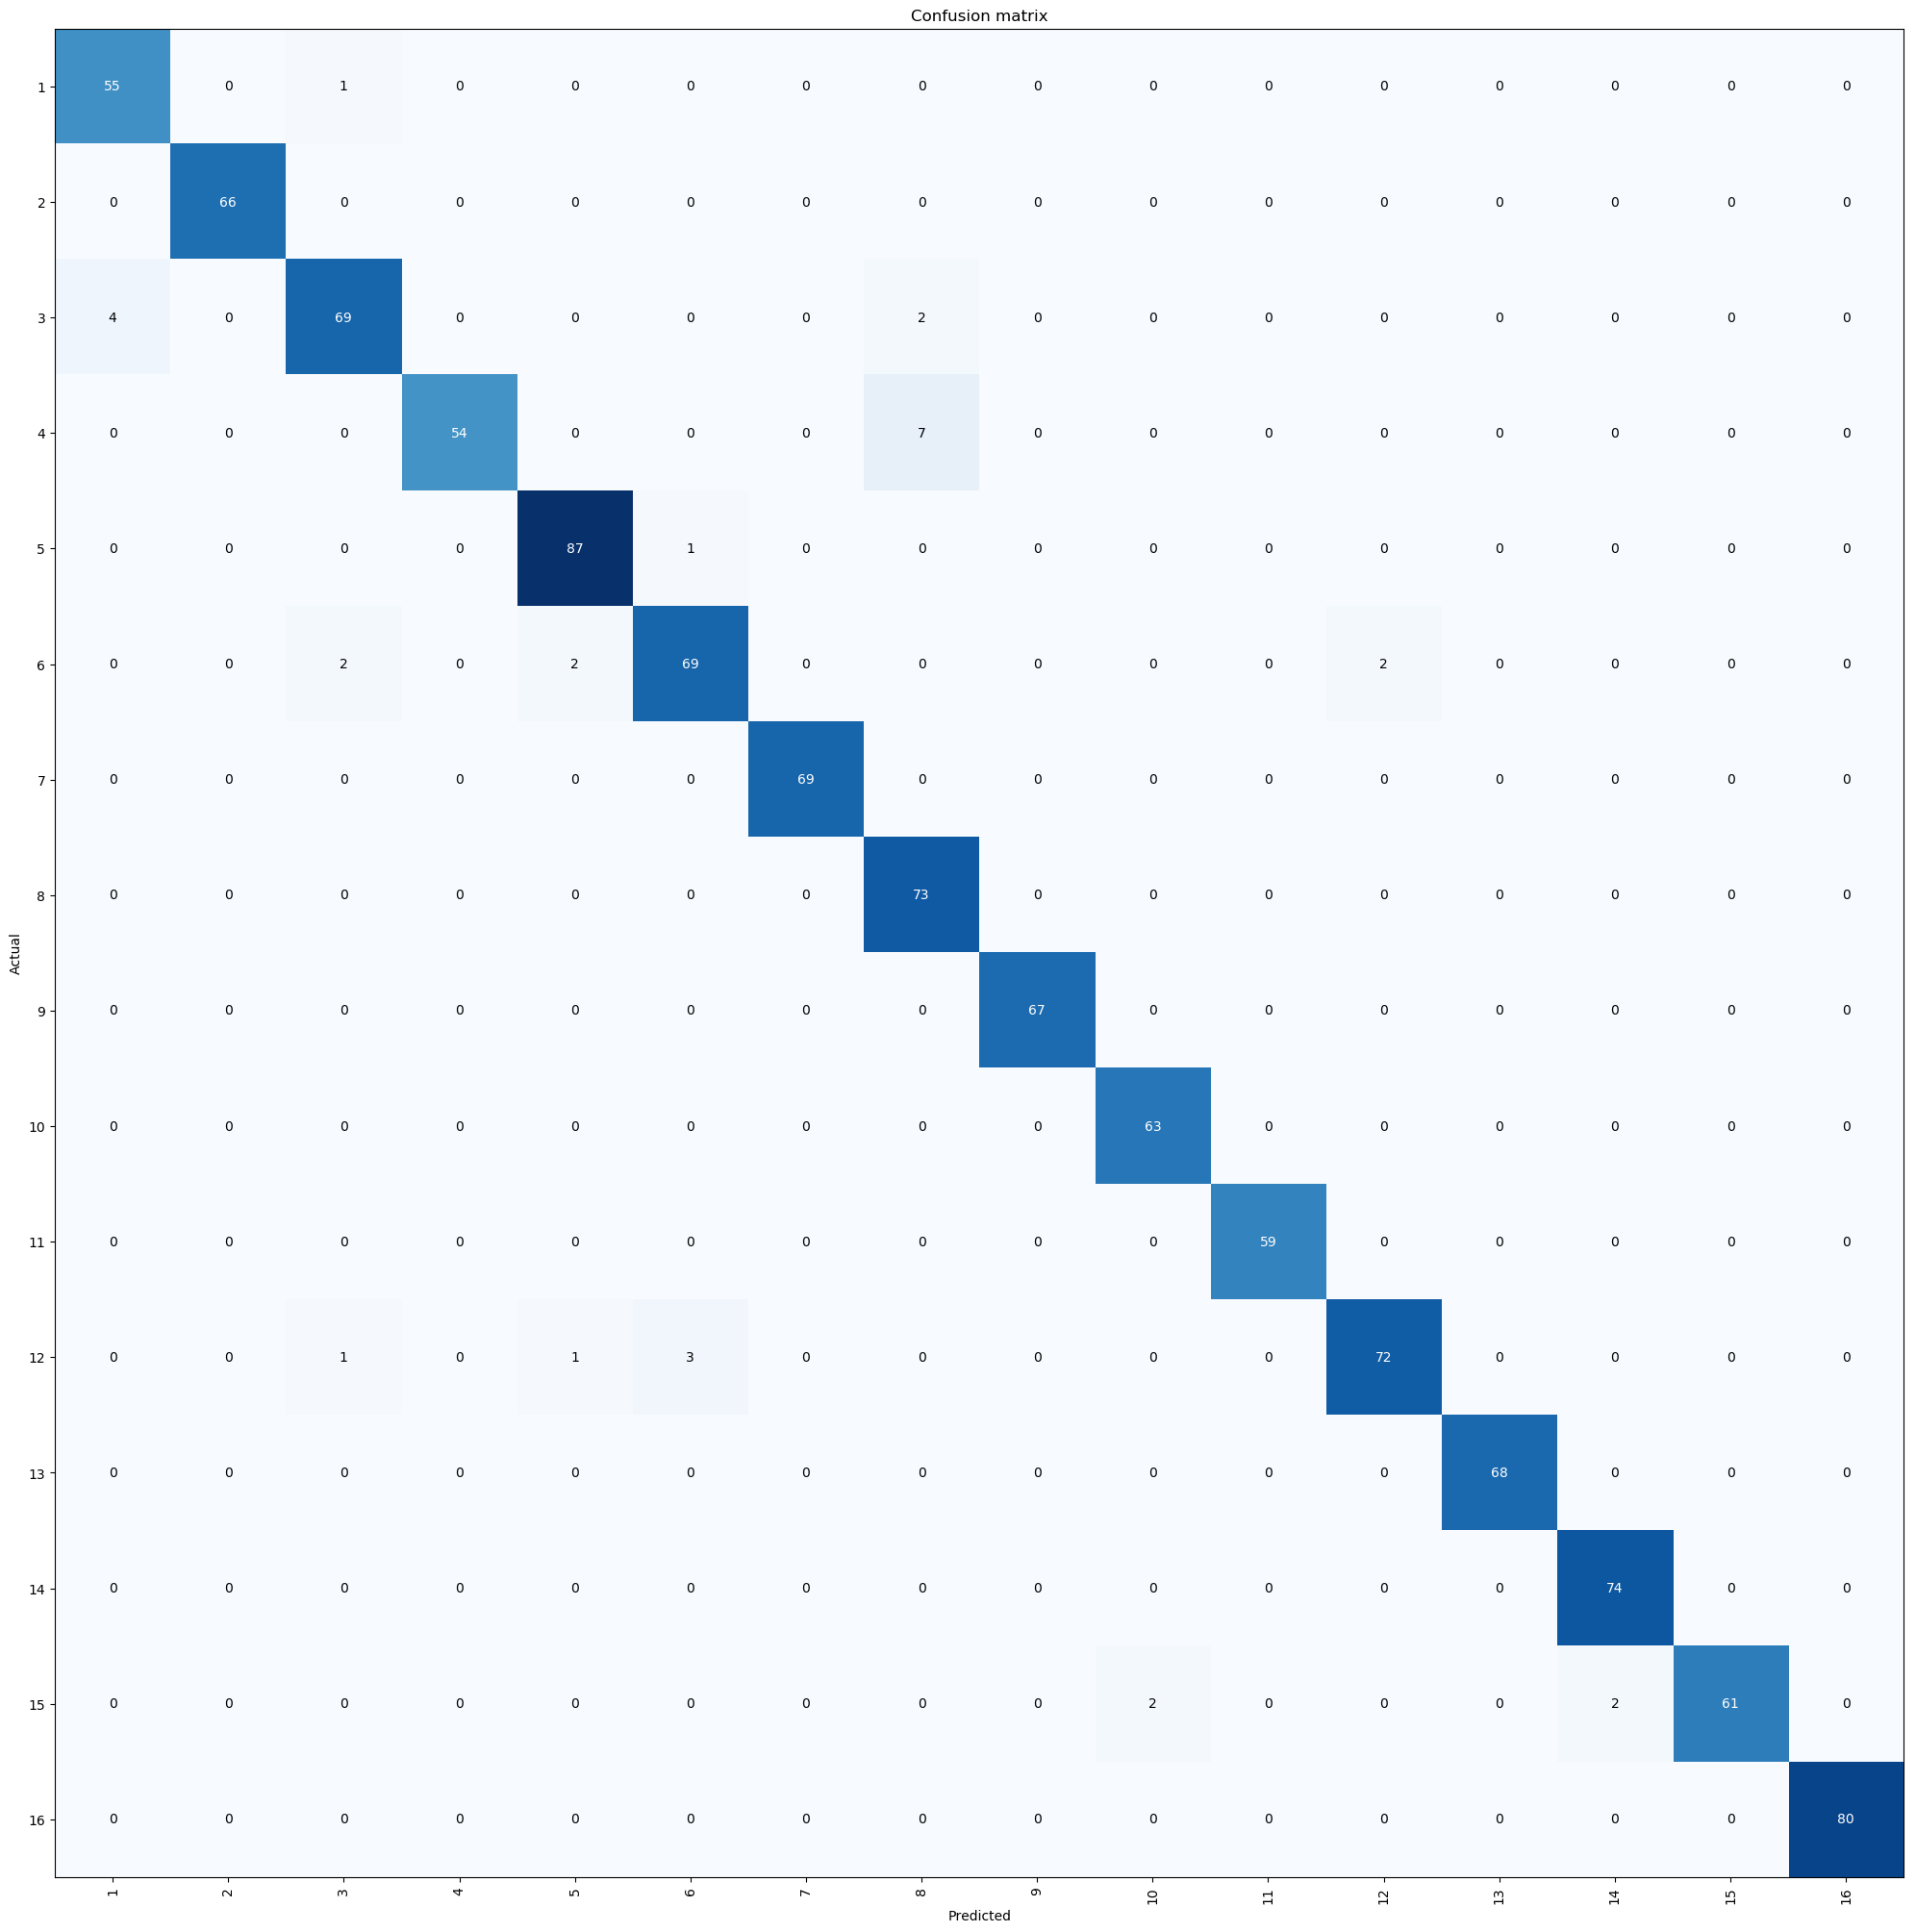

In [30]:
interp.plot_confusion_matrix(figsize=(20,20), dpi=100)

In [31]:
interp.most_confused(min_val=1)

[(4, 8, 7),
 (3, 1, 4),
 (12, 6, 3),
 (3, 8, 2),
 (6, 3, 2),
 (6, 5, 2),
 (6, 12, 2),
 (15, 10, 2),
 (15, 14, 2),
 (1, 3, 1),
 (5, 6, 1),
 (12, 3, 1),
 (12, 5, 1)]

In [32]:
learn.save('/kaggle/output/fast-ai-models/stage-2-50')

In [33]:
path = learn.path

In [34]:
learn.export('/kaggle/output/fast-ai-models/lego.pkl')

In [35]:
defaults.device = torch.device('cpu')

In [36]:
lego_learn = load_learner('/kaggle/output/fast-ai-models', 'lego.pkl')

In [37]:
pred_path = path/'test'
pred_fn_paths = get_image_files(pred_path)

In [38]:
for pred_fn_path in pred_fn_paths:
    img = open_image(pred_fn_path)
    pred_class,pred_idx,outputs = lego_learn.predict(img)
    print(pred_fn_path, pred_class)

/kaggle/input/lego-dataset/test/5436.png 6
/kaggle/input/lego-dataset/test/4914.png 2
/kaggle/input/lego-dataset/test/4580.png 12
/kaggle/input/lego-dataset/test/5805.png 15
/kaggle/input/lego-dataset/test/4517.png 16
/kaggle/input/lego-dataset/test/4850.png 15
/kaggle/input/lego-dataset/test/5076.png 15
/kaggle/input/lego-dataset/test/6378.png 1
/kaggle/input/lego-dataset/test/4965.png 6
/kaggle/input/lego-dataset/test/4986.png 11
/kaggle/input/lego-dataset/test/4662.png 14
/kaggle/input/lego-dataset/test/5189.png 1
/kaggle/input/lego-dataset/test/5292.png 15
/kaggle/input/lego-dataset/test/5071.png 1
/kaggle/input/lego-dataset/test/4656.png 14
/kaggle/input/lego-dataset/test/5344.png 14
/kaggle/input/lego-dataset/test/6255.png 13
/kaggle/input/lego-dataset/test/5037.png 2
/kaggle/input/lego-dataset/test/4862.png 2
/kaggle/input/lego-dataset/test/5911.png 2
/kaggle/input/lego-dataset/test/5650.png 2
/kaggle/input/lego-dataset/test/5875.png 14
/kaggle/input/lego-dataset/test/5206.png 1

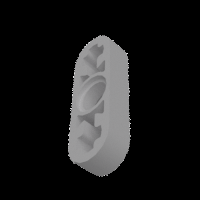

In [39]:
img = open_image('/kaggle/input/lego-dataset/test/5491.png')
img

In [40]:
pred_class,pred_idx,outputs = lego_learn.predict(img)
print(str(pred_class))

13
